# Response time minimization problem for Oslo police district

### Version 4.0

- Goal: Minimize the response time of police vehicles in Oslo police district, Norway.
- The problem is formulated as a capacitated vehicle positioning problem using PuLP.

#### Oslo police district
Oslo police district is the largest police district in the country measured by population - and the smallest district measured by area. The former Asker and Bærum police district and Oslo police district have been merged. From 1 January 2020, Røyken and Hurum municipalities became part of Asker municipality, and thus also within the Oslo police district. In total, the three municipalities have approx. 928,156 inhabitants (as of Q1 2022). The district has just under 3,400 employees.

In [1]:
# import watermark
%reload_ext watermark
%watermark

Last updated: 2024-04-16T20:44:06.981326+02:00

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.22.2

Compiler    : MSC v.1935 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import shapely
from shapely.geometry import Point, LineString, Polygon, MultiPolygon, mapping
from shapely.ops import nearest_points, unary_union
from descartes import PolygonPatch
import pyproj
import geopandas as gpd
import osmnx as ox
import networkx as nx
import pandana as pdna
import pulp
import highspy
import folium
import utilityModule # own custom functions

pd.set_option('display.float_format', lambda x: '%.3f' % x)
ox.settings.log_console=True
ox.settings.use_cache=True
%watermark -w
%watermark -iv

Watermark: 2.4.3

pandana   : 0.7
shapely   : 2.0.3
pandas    : 2.2.1
osmnx     : 1.9.1
pulp      : 2.8.0
folium    : 0.16.0
matplotlib: 3.8.3
networkx  : 3.2.1
geopandas : 0.14.3
pyproj    : 3.6.1
highspy   : 1.5.3
numpy     : 1.26.4



## 0. Load road network

We load a preprocessed graph (road network) from file. This has been prepared using the corresponding preprocessing script.  
The graph is a MultiDiGraph clipped after the boundaries of Oslo police district. Imported as WGS84 (EGSG:4326) and will be converted to UTM33N (EPSG:32633) before the analysis.  
Edges contain road speeds and travel times. Node centrality has been computed and saved locally.

In [3]:
### Load road network from file
oslo_filepath = "../data/oslo/osloDriveImputed.graphml" # with travel time attribute
oslo_graph = ox.load_graphml(oslo_filepath) # originally in WGS84 (EPSG:4326)

In [4]:
oslo_graph = ox.projection.project_graph(oslo_graph, to_crs='EPSG:32633') # if need to project to UTM zone 33N
print(f"Type of oslo_graph: {type(oslo_graph)}")
print(f"CRS of oslo_graph:  {oslo_graph.graph['crs']}")

# plot graph
# fig, ax = ox.plot_graph(oslo_graph, node_size=1, edge_linewidth=0.2, edge_color="w", bgcolor="k")

Type of oslo_graph: <class 'networkx.classes.multidigraph.MultiDiGraph'>
CRS of oslo_graph:  EPSG:32633


Convert graph to GeoDataFrame and plot it.   
`osmnx.utils_graph.graph_to_gdfs(G, nodes=True, edges=True, node_geometry=True, fill_edge_geometry=True)` - Convert a MultiDiGraph to node and/or edge GeoDataFrames.

In [5]:
# converting the graph network to node and edge GeoPandas GeoDataFrames
nodes, edges = ox.graph_to_gdfs(oslo_graph, nodes=True, edges=True)
print(f"type of nodes:{type(nodes)}")
edges.head(2) # verify edges contain speed and travel time

type of nodes:<class 'geopandas.geodataframe.GeoDataFrame'>


osmid          name      highway  oneway reversed  length  \
u   v      key                                                                
110 115    0    5121777  Bråtenalléen  residential   False    False 243.278   
    277510 0    5121777  Bråtenalléen  residential   False     True 151.771   

                                                         geometry  speed_kph  \
u   v      key                                                                 
110 115    0    LINESTRING (264559.267 6653336.868, 264555.742...     32.400   
    277510 0    LINESTRING (264559.267 6653336.868, 264566.273...     32.400   

                travel_time maxspeed lanes width access  ref bridge tunnel  \
u   v      key                                                               
110 115    0         27.000      NaN   NaN   NaN    NaN  NaN    NaN    NaN   
    277510 0         16.900      NaN   NaN   NaN    NaN  NaN    NaN    NaN   

               junction area est_width service  
u   v      key                                  
110 115    0        NaN  NaN       NaN     NaN  
    277510 0        NaN  NaN       NaN     NaN

## 1. Simulate event points

Steps:  
1.1 Load preprocessed population data  
1.2 Event simulation based on population count.  
1.3 Snap points to network (after defined Pandana network)  

### 1.1 Load preprocessed population data  

We load preprocessed population data in 250x250m grid cells from SSB.
- Correct extent: Combined municipalities of  Asker, Bærum and Oslo.
- CRS: WGS84 EPSG:4326, will be converted to UTM33N EPSG:32633 before analysis.

In [6]:
# load preprocessed population data and convert to CRS UTM zone 33N (EPSG:32633)
oslo_polygon_path = "../data/oslo/osloCombinedPolygon.geojson"
population_path = "../data/oslo/osloPopulation.geojson"
oslo_polygon_gdf = gpd.read_file(oslo_polygon_path)
population_gdf = gpd.read_file(population_path)
oslo_polygon_gdf = oslo_polygon_gdf.to_crs(oslo_graph.graph['crs']) # convert to CRS of road network
population_gdf = population_gdf.to_crs(oslo_graph.graph['crs']) # convert to CRS of road network
print(f"type of pop_df: {type(population_gdf)}")
print(f"columns of population_gdf: {population_gdf.columns}")
population_gdf.head(2)

type of pop_df: <class 'geopandas.geodataframe.GeoDataFrame'>
columns of population_gdf: Index(['id', 'population', 'geometry'], dtype='object')


id  population  \
0  22425006607500           7   
1  22425006607750           1   

                                            geometry  
0  POLYGON ((242500.000 6607500.000, 242500.000 6...  
1  POLYGON ((242500.000 6607750.000, 242500.000 6...

### 1.2 Event simulation based on population counts

For each gridcell, simulated events are generated based on the population count and scaled with a self-adjustable factor that ensure the total number of simulated events will fall in the preferred range.

In [7]:
# calculate the number of points to simulate in each grid cell - vectorized version
population_gdf = utilityModule.simulate_event_points(population_gdf, min_range=7650, max_range=7690) # std pop multiplier
# population_gdf = utilityModule.simulate_event_points(population_gdf, min_range=1500, max_range=1550) # few events, fast testing

# # print the number of cells with 0, 1, 2, ..., 9 events
# for i in range(0, 7):
#     print(f"Nr of cells with {i} events: {len(population_gdf[population_gdf['num_points'] == i])}")

# print the cells with the highest number of points
population_gdf.nlargest(3, 'num_points')

Total number of simulated event points: 7652. Target range [7650, 7690], using population multiplier: 0.008347656250000002


id  population  \
2685  22637506649000        2351   
2831  22630006649250        2190   
2832  22632506649250        2014   

                                               geometry  num_points  
2685  POLYGON ((263750.000 6649000.000, 263750.000 6...          20  
2831  POLYGON ((263000.000 6649250.000, 263000.000 6...          18  
2832  POLYGON ((263250.000 6649250.000, 263250.000 6...          17

In [8]:
%%time
# List to hold all generated points
event_points = []
# Iterate over rows in your GeoDataFrame
for _, row in population_gdf.iterrows():
    # Extract number of points to generate for the current row
    num_points = row['num_points']
    if num_points > 0:  # Proceed only if there are points to generate
        # Generate points within the grid cell 
        points = utilityModule.generate_points_within_gridcell(num_points, row['geometry'].bounds)
        event_points.extend(points)

# Create a GeoDataFrame from the generated points
event_points_gdf = gpd.GeoDataFrame(geometry=event_points, crs=population_gdf.crs)
event_points_gdf.head(3)

CPU times: total: 328 ms
Wall time: 490 ms


geometry
0  POINT (243743.693 6617118.754)
1  POINT (243727.486 6617312.213)
2  POINT (243250.956 6616898.409)

In [9]:
# create polygons around high event density areas
high_pop_density_area = utilityModule.generate_high_density_polygon(event_points_gdf, grid_size=100, density_threshold=3.0e-10, 
                                                                    simplification_tolerance=5.0, plot_results=False)

Density: Min: 1.290e-61 | Median: 7.806e-12 | Mean: 5.252e-10 | Max: 1.239e-08


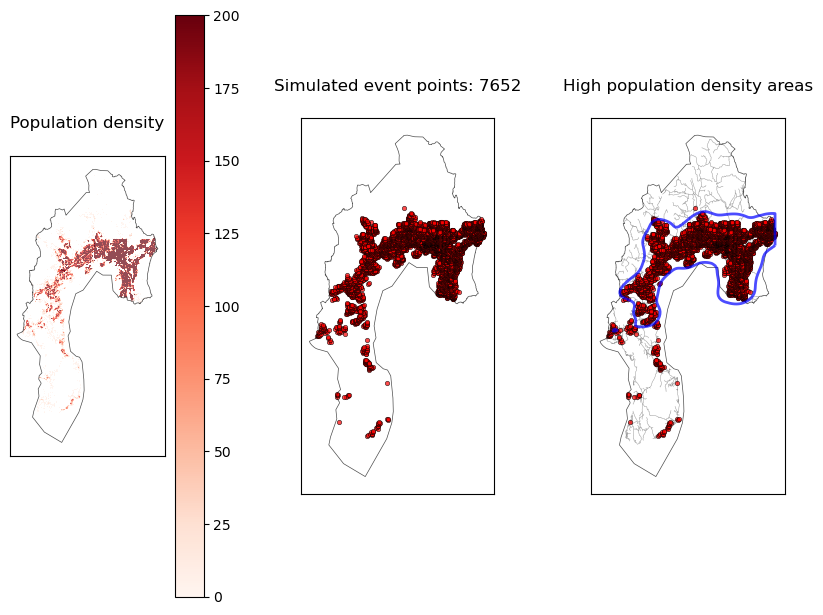

In [10]:
# Plot the population density, simulated event points, and high population density areas side-by-side
utilityModule.plot_population_density_and_event_points(oslo_polygon_gdf, population_gdf, 
                                                       event_points_gdf, high_pop_density_area, edges)

## 2. Police car candidate points

Steps:  
2.1 Add Centrality measures as node attributes  
2.2 Sample candidate points and filter out best candidate points

### 2.1 Add Centrality measure as node attribute

*Closeness centrality is a measure of how close a node is to all other nodes in the network. It is calculated as the reciprocal of the sum of the shortest path distances from the node to all other nodes in the graph.*

*Betweenness centrality is a measure of how many shortest paths pass through a node.*

In [11]:
# if centrality is in the nodes GeoDataFrame, drop it
if 'closeness_centrality' in nodes.columns:
    nodes.drop(columns=['closeness_centrality'], inplace=True)
if 'betweenness_centrality' in nodes.columns:
    nodes.drop(columns=['betweenness_centrality'], inplace=True)

# import node closeness centrality from file
nodes_centrality_import = pd.read_csv("../data/oslo/osloNodeCentrality.csv")

# Since 'osmid' is the index in `nodes`, we can merge on the index
nodes = nodes.merge(nodes_centrality_import, left_index=True, right_on='osmid')

# After the merge, if you want 'osmid' as a column instead of an index, can reset the index
nodes.reset_index(drop=True, inplace=True)
nodes.set_index('osmid', inplace=True)
nodes.head(2)

y          x  street_count    lon    lat highway  ref  \
osmid                                                                   
110   6653336.868 264559.267             4 10.783 59.950     NaN  NaN   
115   6653477.248 264359.699             4 10.780 59.951     NaN  NaN   

                             geometry  closeness_centrality  \
osmid                                                         
110    POINT (264559.267 6653336.868)                 0.001   
115    POINT (264359.699 6653477.248)                 0.001   

       betweenness_centrality  
osmid                          
110                529576.000  
115                667728.667

### 2.2 Sample candidate points and filter out poor candidate points

In [12]:
# random nodes from the graph
SEED = 2
NR_OF_CAR_NODES = 100

# sample X random source nodes from the area high_pop_density_area
car_nodes = nodes[nodes.within(high_pop_density_area.geometry.values[0])]
car_nodes = car_nodes.sample(NR_OF_CAR_NODES, random_state=SEED) # sample X random source nodes
print(f"Total nr of nodes: {len(nodes)}, nr of police car nodes: {len(car_nodes)}")

# make car_nodes into a GeoDataFrame
car_nodes_gdf = gpd.GeoDataFrame(car_nodes, geometry=gpd.points_from_xy(car_nodes.x, car_nodes.y))
car_nodes.head(2)

Total nr of nodes: 17638, nr of police car nodes: 100


y          x  street_count    lon    lat         highway  \
osmid                                                                           
3608802819 6650686.176 265222.049             3 10.798 59.927             NaN   
1334786288 6653829.661 263212.864             1 10.759 59.954  turning_circle   

            ref                        geometry  closeness_centrality  \
osmid                                                                   
3608802819  NaN  POINT (265222.049 6650686.176)                 0.001   
1334786288  NaN  POINT (263212.864 6653829.661)                 0.001   

            betweenness_centrality  
osmid                               
3608802819              737797.833  
1334786288                   0.000

Input nr of car nodes: 100
Remaining nr of car nodes: 80, after discarding the 20 (20%) remote car nodes with lowest closeness centrality
Centrality Measure: closeness


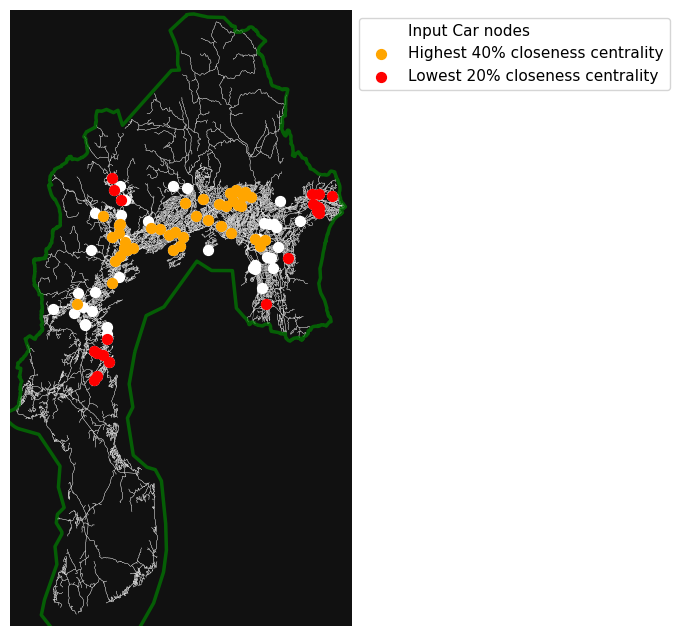

In [13]:
# Filter Car nodes by closeness centrality
car_nodes_gdf_central1 = utilityModule.filter_by_centrality(geo_df=car_nodes_gdf, district_boundary=oslo_polygon_gdf, 
                            top_percent=0.4, bottom_percent=0.20, input_graph=oslo_graph, centrality_measure="closeness", plot=True)

Input nr of car nodes: 80
Remaining nr of car nodes: 64, after discarding the 16 (20%) remote car nodes with lowest betweenness centrality
Centrality Measure: betweenness


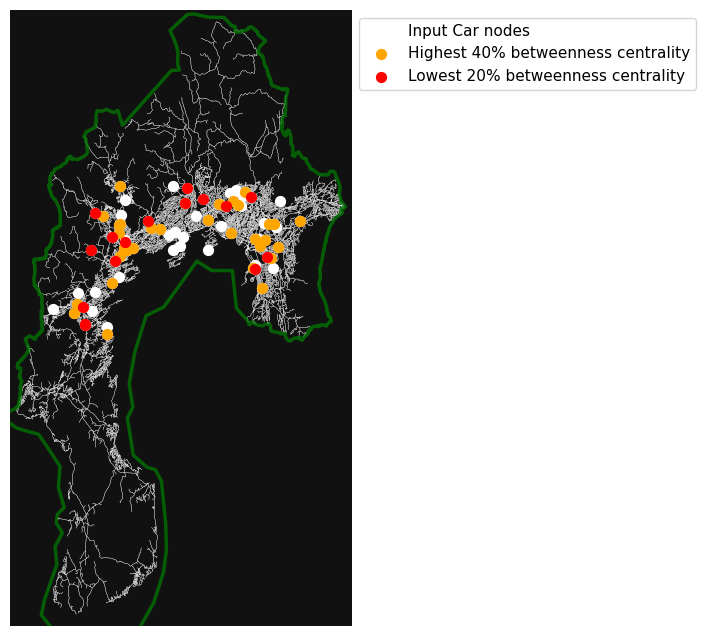

In [14]:
# Filter Car nodes by betweenness centrality
car_nodes_gdf_central2 = utilityModule.filter_by_centrality(geo_df=car_nodes_gdf_central1, district_boundary=oslo_polygon_gdf, 
                            top_percent=0.4, bottom_percent=0.20, input_graph=oslo_graph, centrality_measure="betweenness", plot=True)

Input nr of car nodes: 64
Remaining nr of car nodes: 23, after removing the 41 nodes that are within 2000 m of each other



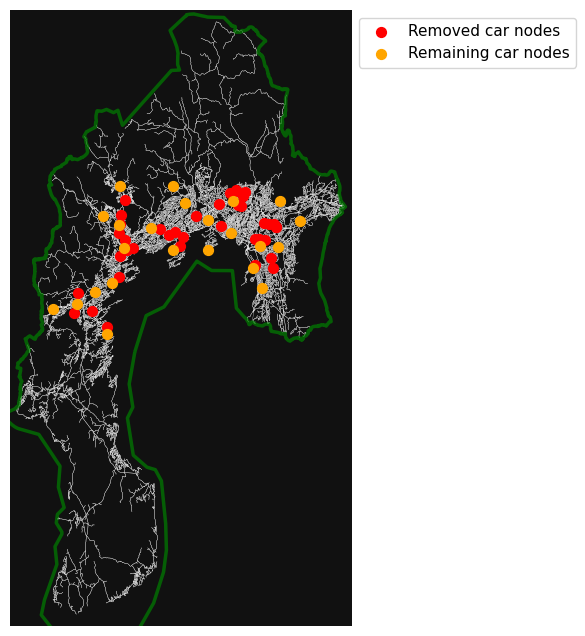

In [15]:
# Filter Car nodes by proximity to each other
car_nodes_gdf_filtered = utilityModule.filter_nodes_by_proximity(geo_df=car_nodes_gdf_central2, district_boundary=oslo_polygon_gdf, 
                             min_distance=2000, input_graph=oslo_graph, criterion_col='betweenness_centrality', prefer='higher', plot=True)

## 3. Define the Pandana network

We use the GeoDataFrames from `osmnx` to create a `pandana` network with both ``length`` and ``travel_time`` as edge weights.  
We have to specify which one to use when querying the network (cannot calculate with both at the same time).

In [16]:
# reset index so our origins and destinations are not in index
edges = edges.reset_index()
# nodes = nodes.reset_index()

# create network with pandana
oslo_network_pdna = pdna.Network(node_x=nodes['x'], node_y=nodes['y'], edge_from=edges['u'], edge_to=edges['v'], 
                                edge_weights=edges[["length", "travel_time"]], twoway=True)

# Print stats about the network
print(f"type of oslo_network_pdna: {type(oslo_network_pdna)}")
print(f"Network nodes:")
oslo_network_pdna.nodes_df.head(2)

type of oslo_network_pdna: <class 'pandana.network.Network'>
Network nodes:


x           y
osmid                       
110   264559.267 6653336.868
115   264359.699 6653477.248

In [17]:
print(f"Network edges: ")
oslo_network_pdna.edges_df.head(2)

Network edges: 


from      to  length  travel_time
0   110     115 243.278       27.000
1   110  277510 151.771       16.900

In [18]:
# %%time
# oslo_network_pdna.precompute(3000)

Recall that the Car Nodes were directly sampled from the road network, while event points were generated outside the road network.  
Therefore, we need to snap the event points to the Pandana network.

In [19]:
# identify nearest node to each event point
event_points_gdf['nearest_node'] = oslo_network_pdna.get_node_ids(event_points_gdf.geometry.x, event_points_gdf.geometry.y, mapping_distance=1000)

# With nearest_node attribute, find osm x,y coordinates
event_points_gdf = event_points_gdf.merge(nodes[['x', 'y']], left_on='nearest_node', right_index=True, suffixes=('', '_nearest_node'))
event_points_gdf.head(2)

geometry  nearest_node          x           y
0  POINT (243743.693 6617118.754)    8319326303 243705.222 6617211.372
1  POINT (243727.486 6617312.213)    8319326012 243686.353 6617232.551

In [20]:
# Get list of nearest node ids for event locations
event_nodes_pdna = oslo_network_pdna.get_node_ids(x_col=event_points_gdf.geometry.x, y_col=event_points_gdf.geometry.y).values
print("Length of event_nodes_pdna: ", len(event_nodes_pdna))
print("Number of unique nodes: ", len(np.unique(event_nodes_pdna)))
event_nodes_pdna[:5]

# get the nearest node ids (in this case, just selecting the 'osmid')
car_nodes_pdna = oslo_network_pdna.get_node_ids(x_col=car_nodes_gdf_filtered.x, y_col=car_nodes_gdf_filtered.y).values
car_nodes_pdna[:5]

Length of event_nodes_pdna:  7652
Number of unique nodes:  4845


array([ 126646959,  274990707,  724111155, 1654832678, 3201501510],
      dtype=int64)

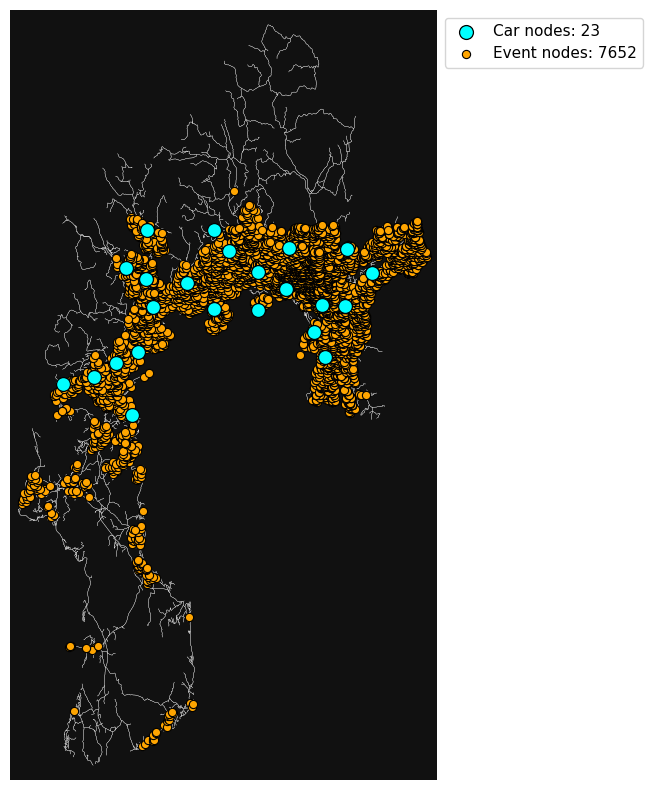

In [21]:
# Plot overview of Car nodes and Event nodes
fig, ax = ox.plot_graph(oslo_graph, node_color="white", node_size=0, edge_linewidth=0.2, edge_color="w", show=False, close=False, figsize=(10,10))
ax.scatter(car_nodes_gdf_filtered['x'], car_nodes_gdf_filtered['y'], c='cyan', edgecolor='black', lw=0.90, s=100, label=f"Car nodes: {len(car_nodes_gdf_filtered)}", zorder=3)
ax.scatter(event_points_gdf['x'], event_points_gdf['y'], c='orange', s=35, edgecolor='black', lw=0.80, label=f"Event nodes: {len(event_points_gdf)}", zorder=2)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=11); plt.show()

## 4. Cost Matrix - Calculate all origin-destination pairs

Building Cost Matrix:
- Cross-join all events and car locations to get all possible origin-destination pairs.
- Compute the travel time of each combination using Pandana `shortest_path_lengths()`

In [22]:
# Creating origins-destination pairs
origins = np.repeat(car_nodes_pdna, len(event_nodes_pdna))
destinations = np.tile(event_nodes_pdna, len(car_nodes_pdna))

In [23]:
%%time
# travel time between each possible pair of car-event combination
distances = oslo_network_pdna.shortest_path_lengths(origins, destinations, imp_name='length')
travel_times = oslo_network_pdna.shortest_path_lengths(origins, destinations, imp_name='travel_time')
print(f"{len(car_nodes_pdna)} origins x {len(event_nodes_pdna)} destinations = {len(origins)} origin-destination pairs (problem size)\n")
print("5 first origin-destination distances [m]     :", distances[:5])
print("5 first origin-destination travel times [sec]:", travel_times[:5])

23 origins x 7652 destinations = 175996 origin-destination pairs (problem size)

5 first origin-destination distances [m]     : [42138.913, 42167.237, 42957.937, 44073.734, 30895.941]
5 first origin-destination travel times [sec]: [2285.9, 2288.4, 2344.9, 2440.9, 1823.3]
CPU times: total: 11.1 s
Wall time: 1.1 s


In [24]:
# describe statistics for travel times - horizontally
travel_times_df = pd.DataFrame(travel_times)
travel_times_df.describe().T

count    mean     std   min     25%     50%      75%      max
0 175996.000 943.540 480.584 0.000 571.000 896.600 1263.000 3978.499

In [25]:
# Restructure the distances and travel times arrays into a DataFrame (Cost Matrix) and add the car and event node ids as columns
# create a DataFrame from the distances and travel times arrays
CostMatrix = pd.DataFrame({'distance': distances, 'travel_time': travel_times})

# add the car and event node ids as columns
CostMatrix['carNodeID'] = np.repeat(car_nodes_pdna, len(event_nodes_pdna))
CostMatrix['eventNodeID'] = np.tile(event_nodes_pdna, len(car_nodes_pdna))
# CostMatrix.head() # distances, travel times, car and event node ids

# merge the distances DataFrame with the car and event nodes DataFrames to get the coordinates
CostMatrix_extended = CostMatrix.merge(nodes[['x', 'y']], left_on='carNodeID', right_index=True, suffixes=('', '_car'))
CostMatrix_extended = CostMatrix.merge(nodes[['x', 'y']], left_on='eventNodeID', right_index=True, suffixes=('', '_event'))
CostMatrix_extended.head(2) # distances, travel times, car and event node coordinates

distance  travel_time  carNodeID  eventNodeID          x           y
0 42138.913     2285.900  126646959   8319326303 243705.222 6617211.372
1 42167.237     2288.400  126646959   8319326012 243686.353 6617232.551

In [26]:
# Save cost matrix to CSV
CostMatrix.to_csv("../data/oslo/osloCostMatrix.csv", index=False)

# drop the distance column from the CostMatrix, just using travel time
CostMatrix.drop(columns="distance", inplace=True)

We have 2 Cost Matrices with distances and travel times between each police car and event node pair.
- ``CostMatrix`` is the lean cost matrix that will be used for further computations in optimization problems. - *saved as local .csv file for later use*
- ``CostMatrix_extended`` is the cost matrix extended with coordinate information. Useful for post-optimization tasks.

# 5. Optimization problem

### 5.1 Formulating the problem
We will use the Python library PuLP to model and solve the optimization problem.   
The objective is to minimize the total response time to events, by optimally positioning a fixed number of police cars.

#### Notation
- $N$ : The set of all nodes in the road network.
- $E$ : The set of events locations, a subset of $N$.
- $P$ : The set of potential police car locations, a subset of $N$.
- $C_{ij}$ : The travel time from police car location $i \in P$ to event location $j \in E$.
- $x_i$ : Binary decision variable where $x_i = 1$ if a police car is positioned at node $i$, and $x_i = 0$ otherwise.
- $y_{ij}$ : Binary decision variable where $y_{ij} = 1$ if the event $j$ is assigned to the police car located at $i$, and $y_{ij} = 0$ otherwise.
- $K$ : The number of police cars available.
- $M$ : The maximum number of events that can be assigned to a police car.

#### Objective Function
The objective is to minimize the total response time to all events. The response time is the travel time from a police car to an event, considering only the assignments where $y_{ij} = 1$.
$$
\text{Minimize} \quad Z = \sum_{i \in P} C_{ij} \cdot y_{ij}
$$

#### Constraints
1. **Police Car Placement Constraint**: Only $K$ police cars are available to be deployed.
$$
\sum_{i \in P} x_i = K
$$

2. **Event Assignment Constraint**: Each event must be assigned to exactly one police car.
$$
\sum_{i \in P} y_{ij} = 1 \quad \forall j \in E
$$

3. **Validity Constraint**: An event can only be assigned to a police car if that car is positioned at a node.
$$
y_{ij} \leq x_i \quad \forall i \in P, \forall j \in E
$$

4. **Capacity Constraint**: Each police car can only be assigned to a limited number of events.
$$
\sum_{j \in E} y_{ij} \leq M \cdot x_i \quad \forall i \in P
$$

5. **Non-Negativity and Integrality**: Ensure that the decision variables are binary.
$$
x_i \in \{0, 1\} \quad \forall i \in P
$$
$$
y_{ij} \in \{0, 1\} \quad \forall i \in P, \forall j \in E
$$


### 5.2 Preprocessing data structures for efficient computation

In [27]:
# add suffix to duplicate eventNodeIDs
CostMatrix_suffix = utilityModule.suffix_duplicate_nodes(CostMatrix)
CostMatrix_suffix.head(2)

travel_time  carNodeID   eventNodeID
0     2285.900  126646959  8319326303_1
1     2288.400  126646959  8319326012_1

In [28]:
### Problem Setup parameters
# Problem reduction
DISCARD_THRESHOLD = 0.00

# Constants
NR_OF_CARS = 4
CAR_CAPACITY = 3500

# # Sets
P = CostMatrix_suffix['carNodeID'].unique()  # All car locations
E = CostMatrix_suffix['eventNodeID'].unique()  # Events
nr_of_unique_events = len(E)

# Preprocess the cost matrix: convert to dict and reduce problem size
CostMatrix_dict_reduced = utilityModule.preprocess_cost_matrix(CostMatrix_suffix, discard_threshold=DISCARD_THRESHOLD, verbose=True)

Filtering out 0% highest travel times - keeping only travel times <= 3978 sec, or 66.3 min
Original nr of pairs: 175996 | Filtered nr of pairs: 175996
Original max travel time: 3978.499 | Filtered max travel time: 3978.499


### 5.2 Setup LP problem

In [29]:
%%time
# Define PuLP problem
problem = utilityModule.define_pulp_problem(CostMatrix_suffix, CostMatrix_dict_reduced, 
    nr_of_cars=NR_OF_CARS, car_capacity=CAR_CAPACITY, problem_name="PoliceCarLocationOptimization", verbose=True)

Number of police car locations: 23
Number of events: 7652
Number of decision variables: 176019
Number of constraints: 183672
Number of non-zero coefficients: 176019
Number of non-zero coefficients in the objective function: 175992
CPU times: total: 5.42 s
Wall time: 7.84 s


### 5.5 Run solver - PULP_CBC (COIN-OR Branch and Cut)

The solver is first run with relaxed integer variable constraint (`mip=False`) for fast computation.  
If the solver does not find all integer solutions, it is run again use proper integer constraints (`mip=True`).


In [30]:
%%time
# Run the solver
print(f"(Note: Currently reducing the Cost matrix by {DISCARD_THRESHOLD*100:.0f}%)")
solve = utilityModule.run_solvers(problem, P, nr_of_locations=NR_OF_CARS, 
                                solver_name='PULP_CBC_CMD', forceMIP=False, plot=False)

(Note: Currently reducing the Cost matrix by 0%)
Optimal police car locations found: 4/4 in 132.79 seconds: [3348672774  619507871 2694606669 3516220001]
Solver: PULP_CBC_CMD | Status: 1 (Optimal)
Objective function value (total response time): 2806641.0590 seconds, or 46777.35 minutes, or 779.62 hours
CPU times: total: 11.6 s
Wall time: 2min 21s


### 5.6 Extract results for inspection

In [31]:
# Extract optimal police car locations
optimal_locations = {i: problem.variablesDict()[f"x_{i}"].varValue for i in P if problem.variablesDict()[f"x_{i}"].varValue == 1}
# print("Optimal police car locations:", optimal_locations.keys())

# convert to geodataframe for plotting. Should contain the carNodeID and the geometry (Point)
optimal_locations_gdf = gpd.GeoDataFrame(geometry=[Point(nodes.loc[node, 'x'], nodes.loc[node, 'y']) for node in optimal_locations.keys()], crs="EPSG:32633")
optimal_locations_gdf['carNodeID'] = optimal_locations.keys()
carNodeID_list = list(optimal_locations_gdf['carNodeID'])

car_to_events_df = utilityModule.create_car_to_events_df(CostMatrix_extended, optimal_locations, problem, 
                                                         CAR_CAPACITY, nr_of_unique_events, verbose=True)
car_to_events_df.to_csv("../data/oslo/osloCarToEventsAssignment.csv", index=False) # export the car to events assignment to CSV

Car 3348672774 is assigned 1639/3500 events
Car 619507871 is assigned 2229/3500 events
Car 2694606669 is assigned 2524/3500 events
Car 3516220001 is assigned 1260/3500 events
Summing the events for each car gives 7652 events, which should equal the total number of unique events: 7652


## 6. Visualization

### 6.1 Plot the optimal police car locations and assigned events

Input parameters:
- Possible police car locations: 23 | Optimal locations in solution: 4
- Events: 7652 | Max event capacity per police car: 3500

Solution from Linear Programming (LP) model:
Goal: minimize objective function (total response time)
Objective function value: 2806641 sec | 46777.4 min | 779.62 hours

Car id: 3348672774 handles 1639 events | Capacity: 46.83% | Total response time: 15924.32 min | Median: 7.58 min | Avg: 9.72 min
Car id: 619507871 handles 2229 events | Capacity: 63.69% | Total response time: 11368.29 min | Median: 4.93 min | Avg: 5.10 min
Car id: 2694606669 handles 2524 events | Capacity: 72.11% | Total response time: 13640.67 min | Median: 4.88 min | Avg: 5.40 min
Car id: 3516220001 handles 1260 events | Capacity: 36.00% | Total response time: 5844.06 min | Median: 4.64 min | Avg: 4.64 min


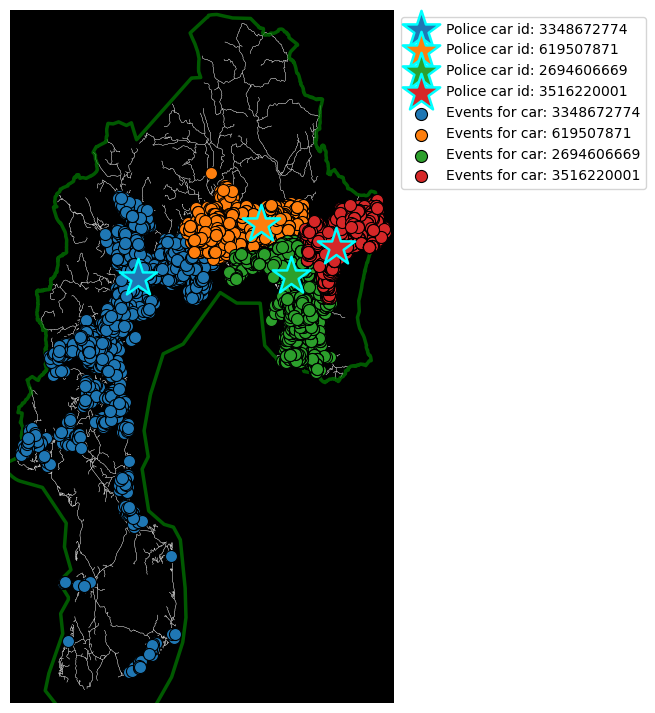

CPU times: total: 2.27 s
Wall time: 3.37 s


In [32]:
%%time
# Plot the optimal car locations and the assigned events
utilityModule.plot_optimal_allocations(oslo_graph, oslo_polygon_gdf, optimal_locations_gdf, car_to_events_df, 
                car_nodes_gdf_filtered, nr_of_unique_events, NR_OF_CARS, CAR_CAPACITY, problem, figsize=(9,9))

## 6.2 Visualize Isochrones - reach in different time intervals
We visualize the collective reach of the police cars in the district with different time intervals.  
We plot isochrones as buffers to get more faithful isochrones than convex hulls can offer.

In [33]:
# Define how many trip times to visualize
TRIP_TIMES = [8, 20, 40]  # in minutes
ISO_COLORS = ['royalblue', 'magenta', 'yellow']  # Long, Middle, Short ranges

Isochrone polygons for the travel times: [8, 20, 40] minutes


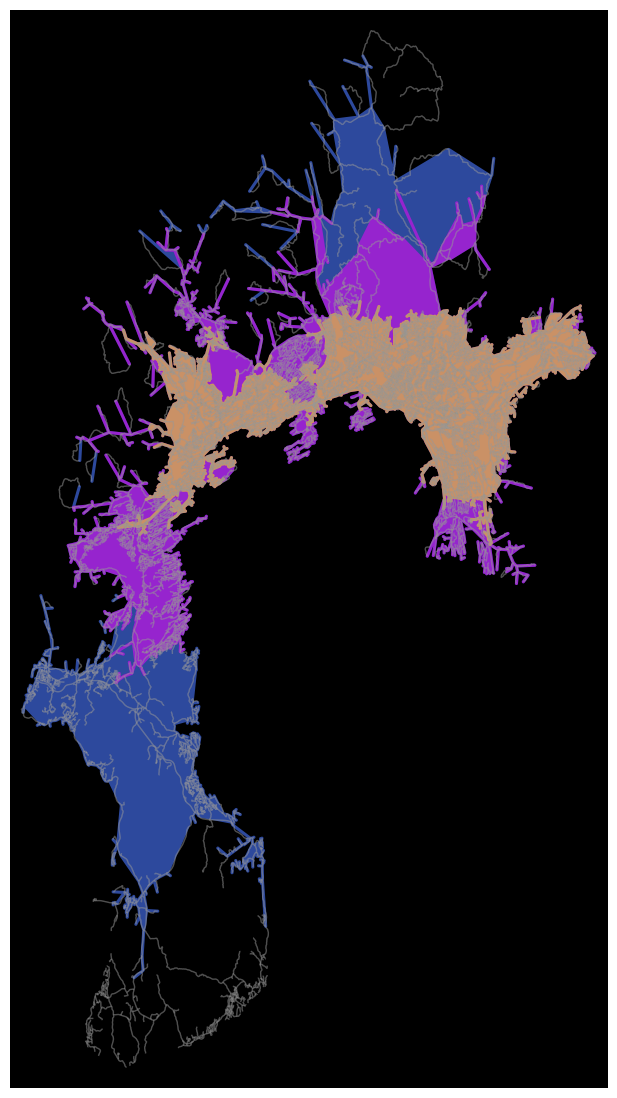

CPU times: total: 1min 22s
Wall time: 1min 52s


In [34]:
%%time
# Generate isochrone polygons
isochrone_polys = utilityModule.make_iso_polys(oslo_graph, TRIP_TIMES, carNodeID_list, 
                                                edge_buff=100, node_buff=0, infill=True)
# Merge isochrones
merged_isochrones = utilityModule.merge_isochrones(oslo_graph, isochrone_polys)
# Plotting the graph and merged isochrones
fig, ax = ox.plot_graph(oslo_graph, show=False, close=False, edge_color='#999999', 
                        edge_alpha=0.3, node_size=0, bgcolor='k', figsize=(14, 14))

# Plotting merged isochrones with colors
for i, (merged_poly, color) in enumerate(zip([merged_isochrones[0], merged_isochrones[1], merged_isochrones[2]], ISO_COLORS)):
    alpha_value = 0.7 if i == 0 else 0.5  # less transparent long-range(i=0)
    if isinstance(merged_poly, MultiPolygon):
        for poly in merged_poly.geoms:
            patch = PolygonPatch(poly, fc=color, ec='none', alpha=alpha_value, zorder=-1)
            ax.add_patch(patch)
    else:
        patch = PolygonPatch(merged_poly, fc=color, ec='none', alpha=alpha_value, zorder=-1)
        ax.add_patch(patch)
print("Isochrone polygons for the travel times:", TRIP_TIMES, "minutes")
plt.show()

### 6.3 Visualize isochrones on interactive map

In [35]:
%%time
# Plot leaflet map
isochrone_map = utilityModule.plot_leaflet_map(oslo_graph, TRIP_TIMES, merged_isochrones, oslo_polygon_gdf, background_poly=True)
isochrone_map

CPU times: total: 703 ms
Wall time: 1.19 s
